In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install mediapipe
!pip install tensorflow

In [63]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import albumentations as A
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

def adjust_gamma(image, gamma=1.5):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)



def extract_hand_landmarks(image):
    """
    Extracts 21 hand landmarks (x, y, z) from an image using MediaPipe Hands.

    Returns:
        - (63,) NumPy array if hand is detected
        - Zero-filled (63,) array if no hand is detected
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_rgb = adjust_gamma(image_rgb, gamma=1.5)  # Apply gamma correction
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        return np.array([[lm.x, lm.y, lm.z] for lm in landmarks.landmark]).flatten()  # (63,)
    else:
        return np.zeros((21, 3)).flatten()  # (63,)




def preprocess_dataset(dataset_dir, max_images_per_class=50):
    """
    Preprocess dataset by extracting hand landmarks, limiting to 50 images per class.

    Args:
        dataset_dir (str): Path to dataset directory.
        max_images_per_class (int): Maximum number of images to process per class.

    Returns:
        X (np.array): Extracted hand landmarks.
        y (np.array): Corresponding class labels.
    """
    j=1
    print("\n🔄 Starting dataset loading...\n")
    X, y = [], []

    for class_name in os.listdir(dataset_dir):  # Loop through class folders
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip non-folder files

        # Get image files (limit to 50 images)
        image_files = sorted(os.listdir(class_dir))[:max_images_per_class]

        print(f"📂 Processing class: {class_name} ({len(image_files)} images)")

        for i, image_name in enumerate(image_files):
            image_path = os.path.join(class_dir, image_name)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Unable to load {image_path}")
                continue

            landmarks = extract_hand_landmarks(image)  # Extract landmarks

            if landmarks is not None:
                X.append(landmarks)  # Append features
                y.append(class_name)  # Append label

                if (i + 1) % 10 == 0:
                  print(f"   ✅ Processed {i + 1}/{len(image_files)} images in {class_name}")

        print(f"✅ Completed class: {class_name}\n")
        print(j)
        j+=1

    print("✅ Dataset loading complete!\n")

    return np.array(X), np.array(y)

# Example usage
dataset_dir = "/content/drive/MyDrive/Miniproject (1)/Indian"  # Replace with your dataset path
X, y = preprocess_dataset(dataset_dir, max_images_per_class=100)

# Encode labels (e.g., "A", "B", "C" → 0, 1, 2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


import pickle

# Save the LabelEncoder to a specific directory
save_path = "/content/drive/MyDrive/ISL_Recognition/label_encoder.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(label_encoder, f)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)



🔄 Starting dataset loading...

📂 Processing class: Q (100 images)
   ✅ Processed 10/100 images in Q
   ✅ Processed 20/100 images in Q
   ✅ Processed 30/100 images in Q
   ✅ Processed 40/100 images in Q
   ✅ Processed 50/100 images in Q
   ✅ Processed 60/100 images in Q
   ✅ Processed 70/100 images in Q
   ✅ Processed 80/100 images in Q
   ✅ Processed 90/100 images in Q
   ✅ Processed 100/100 images in Q
✅ Completed class: Q

1
📂 Processing class: X (100 images)
   ✅ Processed 10/100 images in X
   ✅ Processed 20/100 images in X
   ✅ Processed 30/100 images in X
   ✅ Processed 40/100 images in X
   ✅ Processed 50/100 images in X
   ✅ Processed 60/100 images in X
   ✅ Processed 70/100 images in X
   ✅ Processed 80/100 images in X
   ✅ Processed 90/100 images in X
   ✅ Processed 100/100 images in X
✅ Completed class: X

2
📂 Processing class: V (100 images)
   ✅ Processed 10/100 images in V
   ✅ Processed 20/100 images in V
   ✅ Processed 30/100 images in V
   ✅ Processed 40/100 images in

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

# Define the ViT model
def create_vit(input_shape, num_classes, num_layers=6, num_heads=8, hidden_dim=64):
    inputs = layers.Input(shape=input_shape)

    # Patch embedding (Directly project the input into a higher-dimensional space)
    embedded = layers.Dense(hidden_dim)(inputs)

    # Positional embeddings
    position_indices = tf.range(input_shape[0])  # Generate indices for sequence length
    positions = layers.Embedding(input_dim=input_shape[0], output_dim=hidden_dim)(position_indices)
    positions = tf.expand_dims(positions, axis=0)  # Add batch dimension
    embedded = layers.Add()([embedded, positions])  # Add positional embeddings

    # Transformer encoder
    for _ in range(num_layers):
        # Multi-head self-attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)(embedded, embedded)
        embedded = layers.Add()([embedded, attention_output])
        embedded = layers.LayerNormalization()(embedded)

        # Feed-forward network
        ffn_output = layers.Dense(hidden_dim * 2, activation='relu')(embedded)
        ffn_output = layers.Dense(hidden_dim)(ffn_output)
        embedded = layers.Add()([embedded, ffn_output])
        embedded = layers.LayerNormalization()(embedded)

    # Classification head
    x = layers.GlobalAveragePooling1D()(embedded)  # Reduces sequence dimension
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Example usage
input_shape = (21, 3)  # Input shape for hand landmarks

# Check and remap labels
print("Original labels:", np.unique(y_train))
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print("Remapped labels:", np.unique(y_train))

# Set num_classes based on the remapped labels
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

# Create the ViT model
vit_model = create_vit(input_shape, num_classes)

# Compile the model
vit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
vit_model.fit(X_train, y_train, epochs=50, batch_size=32)

Original labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Remapped labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Number of classes: 35
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 61s 180ms/step - accuracy: 0.0534 - loss: 3.6723
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.2548 - loss: 2.4128
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.4856 - loss: 1.6400
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - accuracy: 0.7084 - loss: 0.9720
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.8337 - loss: 0.6053
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.8904 - loss: 0.4052
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.9089 - loss: 0.3163
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9269 - loss: 0.2184
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━

In [67]:
model_save_path = '/content/drive/MyDrive/ISL_Recognition/vit_model.h5'  # Path to save the model
vit_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/ISL_Recognition/vit_model.h5


In [81]:
import pickle

# Load the LabelEncoder
load_path = "/content/drive/MyDrive/ISL_Recognition/label_encoder.pkl"
with open(load_path, 'rb') as f:
    label_encoder = pickle.load(f)



In [97]:
# Ensure X_test has the correct shape
X_test_reshaped = X_test.reshape(-1, 21, 3)

vit_model(tf.ones((1,) + X_test_reshaped.shape[1:]))

# Evaluate the model
test_loss, test_accuracy = vit_model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions
y_pred = vit_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

try:
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
except ValueError:
    print("⚠ Error: Some predicted labels are out of range for inverse_transform.")
# Print some predictions
for i in range(10):
    print(f"True: {label_encoder.inverse_transform([y_test[i]])[0]}, Predicted: {y_pred_labels[i]}")



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9667 - loss: 0.0995
Test Accuracy: 96.86%
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
True: L, Predicted: L
True: A, Predicted: A
True: D, Predicted: D
True: I, Predicted: I
True: U, Predicted: U
True: 9, Predicted: 9
True: L, Predicted: L
True: L, Predicted: L
True: P, Predicted: P
True: U, Predicted: U


Shape of X_test_reshaped: (700, 21, 3)
Dummy input shape: (1, 21, 3)
Test Loss: 0.09060822427272797
Test Accuracy: 96.86%
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
Unique predicted classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Number of classes in label_encoder: 35

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        18
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        18
           A       1.00      1.00      1.00        20
           B       0.91      0.62      0.74   

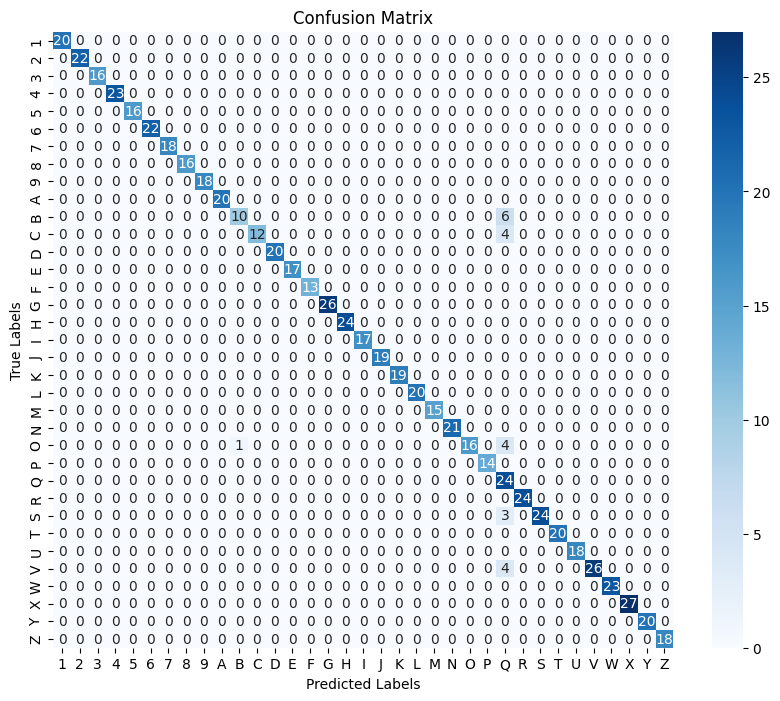


Sample Predictions:
True: L, Predicted: L
True: A, Predicted: A
True: D, Predicted: D
True: I, Predicted: I
True: U, Predicted: U
True: 9, Predicted: 9
True: L, Predicted: L
True: L, Predicted: L
True: P, Predicted: P
True: U, Predicted: U


In [99]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape X_test to match the expected input shape
X_test_reshaped = X_test.reshape(-1, 21, 3)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

# Check model input shape compatibility
dummy_input = tf.ones((1,) + X_test_reshaped.shape[1:])
print("Dummy input shape:", dummy_input.shape)
vit_model(dummy_input)  # Check if the model can process the input

# Evaluate the model
test_loss, test_accuracy = vit_model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions
y_pred = vit_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Check for invalid predictions
print("Unique predicted classes:", np.unique(y_pred_classes))
print("Number of classes in label_encoder:", len(label_encoder.classes_))

# Inverse transform predictions
try:
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    y_test_labels = label_encoder.inverse_transform(y_test)
except ValueError as e:
    print(f"⚠ Error: {e}")
    print("Some predicted labels are out of range for inverse_transform.")
    # Handle the error (e.g., clip predictions to valid range)
    y_pred_classes = np.clip(y_pred_classes, 0, len(label_encoder.classes_) - 1)
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    y_test_labels = label_encoder.inverse_transform(y_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print some predictions
print("\nSample Predictions:")
for i in range(10):
    true_label = y_test_labels[i]
    predicted_label = y_pred_labels[i]
    print(f"True: {true_label}, Predicted: {predicted_label}")